## Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from tqdm import tqdm

## Importing the dataset

In [3]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.25, 0.25, 0.25])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.25, 0.25, 0.25])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.25, 0.25, 0.25])
])


In [4]:
train_set = datasets.ImageFolder(data_dir+'/train', transform=train_transform)
val_set = datasets.ImageFolder(data_dir+'/val', transform=val_transform)
test_set = datasets.ImageFolder(data_dir+'/test', transform=test_transform)

In [5]:
batch_size=32
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

## Defining the Model

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
                nn.Linear(1024, 460),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(460, 2)
)
for param in model.classifier.parameters():
    param.requires_grad = True
    
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 171MB/s]


## Defining criterion and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

## training the model

In [8]:
Epochs = 8
train_losses = {}
train_accu = {}
test_losses = {}
test_accu = {}

for epoch in range(Epochs):
    train_loss = []
    test_loss = []
    train_acc = 0
    test_acc = 0
    
    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.train()  # Ensure the model is in training mode
    
    for img, label in train_loader_tqdm:
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Predictions and accuracy calculation
        _, pred = torch.max(output, 1)
        train_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for training
    train_losses[epoch] = np.mean(train_loss)
    train_accu[epoch] = 100 * train_acc / len(train_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current train loss and accuracy
    train_loader_tqdm.set_postfix({
        'train loss': train_losses[epoch], 
        'train accuracy': train_accu[epoch]
    })
    
    # Testing loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{Epochs}")
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    
    with torch.no_grad():  # No gradients during testing
        for img, label in test_loader_tqdm:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            test_loss.append(loss.item())
            
            # Predictions and accuracy calculation
            _, pred = torch.max(output, 1)
            test_acc += (pred == label).sum().item()  # Convert to item for compatibility
    
    # Compute average loss and accuracy for testing
    test_losses[epoch] = np.mean(test_loss)
    test_accu[epoch] = 100 * test_acc / len(test_loader.dataset)  # Accuracy based on total dataset size
    
    # Update the progress bar with current test loss and accuracy
    test_loader_tqdm.set_postfix({
        'test loss': test_losses[epoch], 
        'test accuracy': test_accu[epoch]  # Corrected to 'test accuracy'
    })
    print(f'Epoch{epoch+1}/{Epochs}, Train_loss: {train_losses[epoch]}, Train_acc: {train_accu[epoch]}, Test_loss: {test_losses[epoch]}, Test_acc: {test_accu[epoch]}')

Epoch 1/8: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Epoch1/8, Train_loss: 0.2463621445731517, Train_acc: 89.85812883435582, Test_loss: 0.37910939007997513, Test_acc: 84.77564102564102


Epoch 2/8: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch2/8, Train_loss: 0.17445828181697182, Train_acc: 93.2898773006135, Test_loss: 0.5137414626777173, Test_acc: 79.8076923076923


Epoch 3/8: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch3/8, Train_loss: 0.1471221270439632, Train_acc: 94.55521472392638, Test_loss: 0.47326969131827357, Test_acc: 83.81410256410257


Epoch 4/8: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch4/8, Train_loss: 0.13591742064186765, Train_acc: 94.40184049079754, Test_loss: 0.48021033853292466, Test_acc: 82.21153846153847


Epoch 5/8: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch5/8, Train_loss: 0.1308684443335043, Train_acc: 94.97699386503068, Test_loss: 0.5548228368163108, Test_acc: 81.25


Epoch 6/8: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch6/8, Train_loss: 0.12715968670197791, Train_acc: 95.13036809815951, Test_loss: 0.47764173373579977, Test_acc: 83.65384615384616


Epoch 7/8: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch7/8, Train_loss: 0.12163390893420559, Train_acc: 95.41794478527608, Test_loss: 0.5629871770739555, Test_acc: 81.57051282051282


Epoch 8/8: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

Epoch8/8, Train_loss: 0.11510103098202519, Train_acc: 95.14953987730061, Test_loss: 0.47708051428198817, Test_acc: 84.77564102564102


## Plotting the Loss and Accuracy

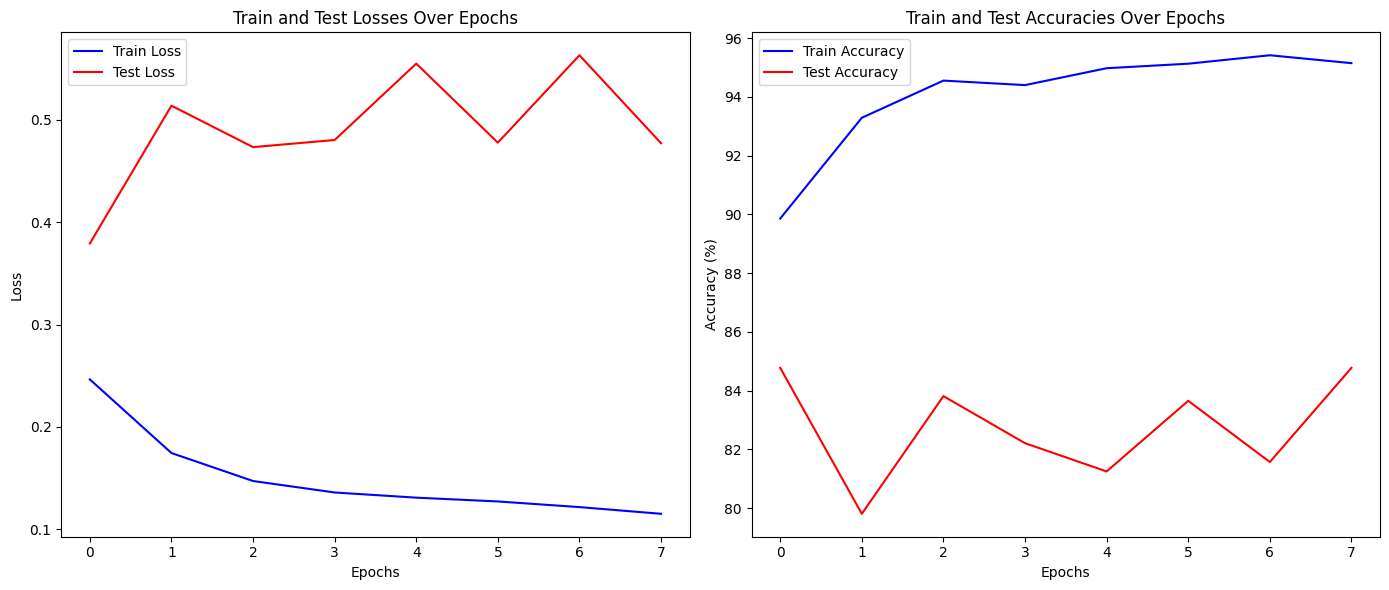

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Losses (Left subplot)
ax1.plot(train_losses.values(), 'b', label='Train Loss')
ax1.plot(test_losses.values(), 'r', label='Test Loss')
ax1.set_title('Train and Test Losses Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting Accuracies (Right subplot)
ax2.plot(train_accu.values(), 'b', label='Train Accuracy')
ax2.plot(test_accu.values(), 'r', label='Test Accuracy')
ax2.set_title('Train and Test Accuracies Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()